# IA Pratique : TP2

# Medical Object Detection : kidney stones

In this second TP, we focus on the case of Object Detection in the medical field. The dataset is issued from [kaggle](https://www.kaggle.com/datasets/safurahajiheidari/kidney-stone-images) and contains 1300 CT-scans, with 1054 CT-scan in training set, 123 in validation set and 123 in test_set. 

This time, the goal is to predict the location of kidney stones within CT-scan images. In object detection,the detection is generally divided into 2 tasks treated simultaneously : first task consists in predicting the coordinates of the bounding box correspond to the object, and the second task predicts the class corresponding to the detected object.  
In our particular case, there are only 2 classes to be detected : kidney stones or not. We could thus only use the first task, since the predicted bounding box can only correspond to a kidney stone. However, keeping both tasks has some advantages : 
 - The classification can help to remove false detection by prediction the "not a kidney stone" class
 - Many existing object detection models use different classes, and it can be easier to keep the classification part in order to use them
 - On an educational point of view, it brings interesting problematics :)

As previously, this TP is divided in 3 different parts :
 
 - In first part, you are going to prepare the available data
 - In second part you will prepare and train a model
 - Finally, in last part you will analyze the results obtained by your model


## First part : data preparation

First of all, the following cell import each library required for this TP. Ensure you got them all.

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
from PIL import Image
import os
import glob
import numpy as np
import gc
import time
from tqdm import tqdm

from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Conv2d
from torch.nn import MaxPool2d


We are now going to prepare our data loader. As in first TP, we have to prepare a dataset class, which we are going to name KidneyDataset. This class prepare the images and the labels according to a *data_dir*. Complete it according to the following instructions : 
 1. The \_\_init__ function computes 3 lists : *self.data*, *self.bboxes* and *self.labels*. *self.data* contains the relative path to acces image *i*. *self.bbox* contains the coordinate of the bounding box of image *i* and *self.labels* the label of the bounding box in image *i*. Since multiple bounding boxes can be found in the same image, we are going to separate them. If an image has multiple bounding boxes, add each image and bounding boxes individually (if image *i* has 3 bounding boxes, add 3 times the image in *self.data*, each time with a different bounding box)
 2. The \_\_getitem__ function takes an index *idx* as input, and return the corresponding image, label and bounding box as tensors. Don't forget to convert the image in RGB. 

In [8]:
class KidneyDataset(Dataset):
    def __init__(self, data_dir, transform=None):

        self.transform = transform
        self.data_dir = data_dir
        data = glob.glob(data_dir + "/images/*")
        self.data = []
        self.bboxes = []
        self.labels = []
        for d in data:
            label = pd.read_csv(data_dir + "/labels/" + os.path.basename(d).replace(".jpg", '.txt'),
                                delim_whitespace=True, names=['class_id', 'x_min', 'y_min', 'x_max', 'y_max'],
                                header=None)
            for i in range(len(label)):
                self.data.append(d)
                self.bboxes.append([label['x_min'][i],label['y_min'][i],label['x_max'][i],label['y_max'][i]])
                self.labels.append(label['class_id'][i])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        bbox = self.bboxes[idx]
        label = self.labels[idx]
        transform
        if self.transform:
            image = self.transform(image)
        return image, np.array(label, dtype="float32"), np.array(bbox, dtype="float32")

transform = transforms.Compose([
            transforms.ToTensor()
        ])


trainset =  KidneyDataset(data_dir = 'data/train',
                         transform = transform)
valset =  KidneyDataset(data_dir = 'data/valid',
                         transform = transform)
testset =  KidneyDataset(data_dir = 'data/test',
                         transform = transform)

batch_size = 64

train_dl = DataLoader(trainset,batch_size=batch_size, drop_last=False, shuffle=True)
val_dl = DataLoader(valset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dl = DataLoader(testset, batch_size=batch_size, drop_last=False, shuffle=True)

# Run the following test function. 
# You should obtain the following shapes : [b, 3, 320, 391], [b, 2] and [b,4] where b is the size of your batch
for image, label, bbox in train_dl:
    print(f"Shape of image [N, C, H, W]: {image.shape}")
    print(f"Shape of label: {label.shape}")
    print(f"Shape of bbox: {bbox.shape}")

Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torch.Size([64, 4])
Shape of image [N, C, H, W]: torch.Size([64, 3, 320, 391])
Shape of label: torch.Size([64])
Shape of bbox: torc

Now that our data are prepared, we are going to check what they look like. Plot the image and draw a green rectangle on the kidney stone to detect. The given function transforms the coordinate into a drawable bounding box for the [Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) function. Does your data looks good ?
You don't need to plot each image of the dataset, you can only plot the first of each batch for example.

tensor(53.5000) tensor(205.5000) tensor(13.) tensor(11.)


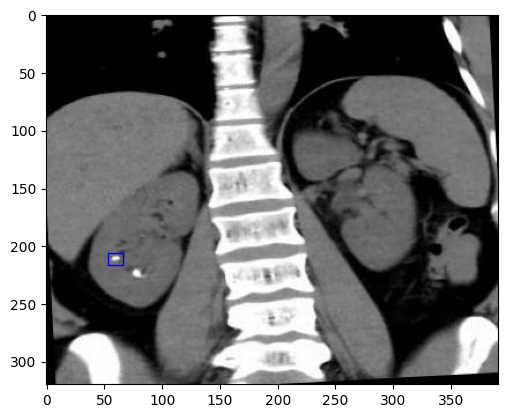

tensor(239.5000) tensor(213.) tensor(21.) tensor(18.)


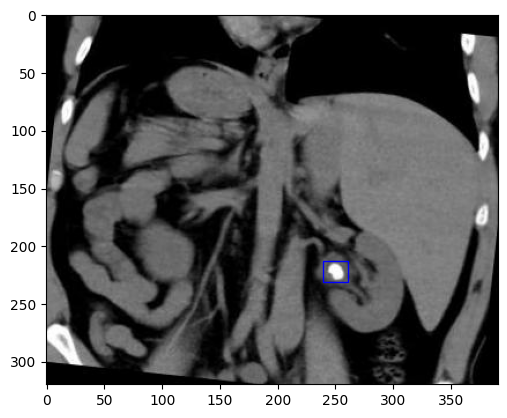

tensor(81.) tensor(223.5000) tensor(8.) tensor(6.)


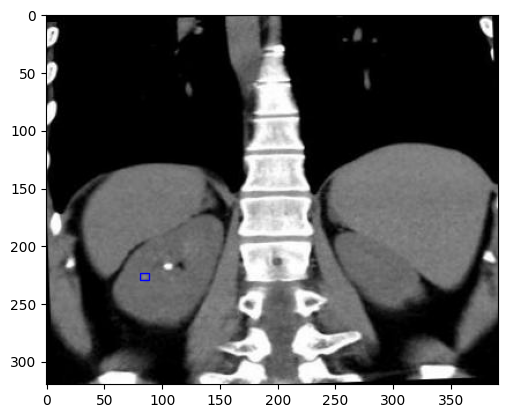

tensor(310.) tensor(231.) tensor(10.) tensor(7.)


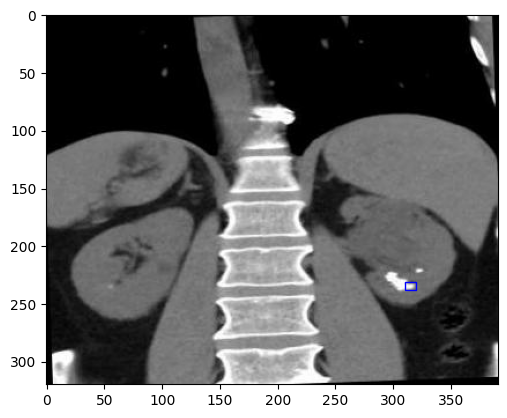

tensor(39.) tensor(245.) tensor(23.) tensor(21.)


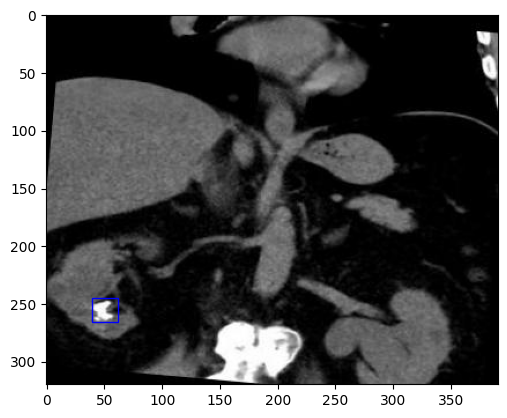

tensor(320.) tensor(185.5000) tensor(8.) tensor(6.)


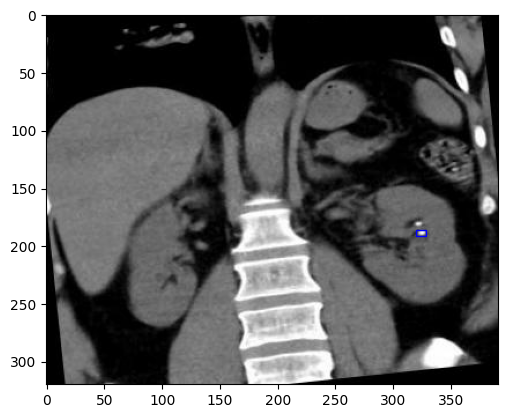

tensor(282.) tensor(227.5000) tensor(30.0000) tensor(29.)


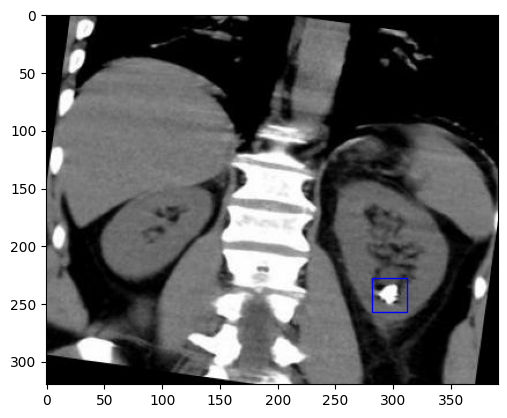

tensor(30.) tensor(306.) tensor(47.) tensor(14.)


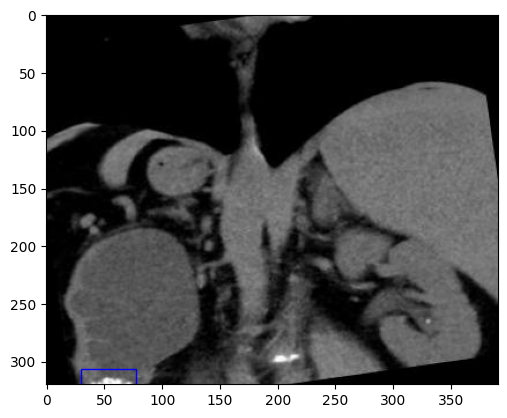

tensor(305.) tensor(212.) tensor(16.) tensor(12.)


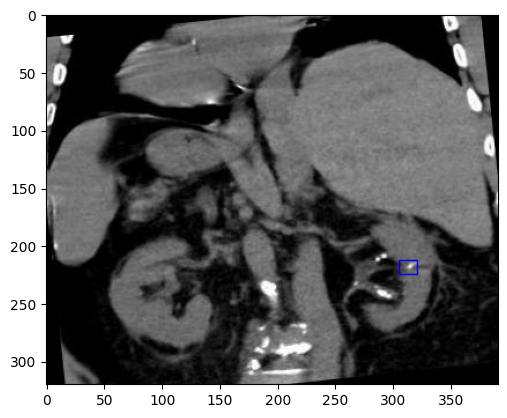

tensor(110.0000) tensor(231.) tensor(8.) tensor(6.)


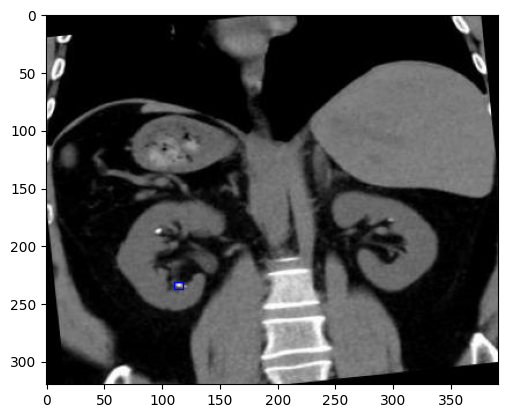

tensor(109.) tensor(171.5000) tensor(5.) tensor(7.)


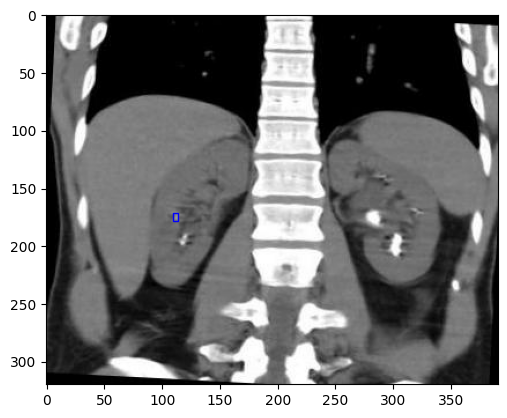

tensor(294.) tensor(196.) tensor(18.) tensor(20.)


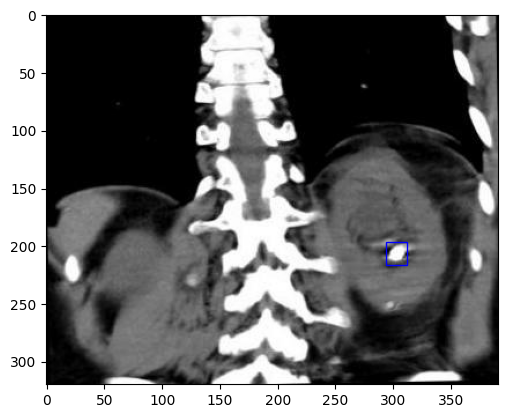

tensor(98.5000) tensor(182.) tensor(4.) tensor(5.)


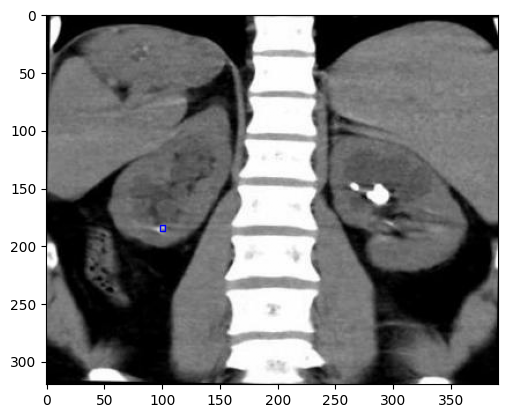

tensor(250.0000) tensor(131.5000) tensor(9.) tensor(11.)


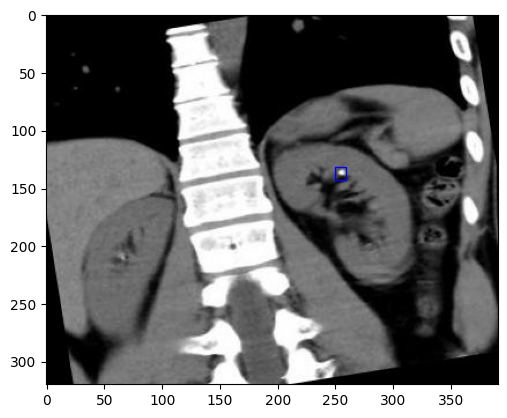

tensor(62.5000) tensor(186.5000) tensor(11.) tensor(9.)


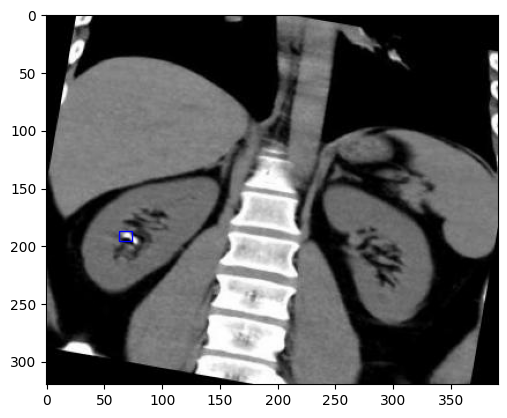

tensor(304.) tensor(277.) tensor(8.) tensor(6.)


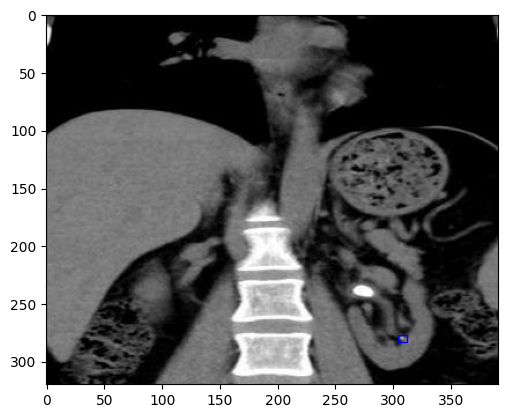

tensor(289.) tensor(157.) tensor(19.) tensor(14.)


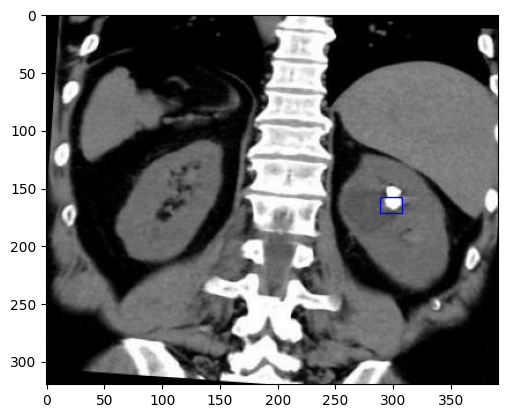

tensor(301.5000) tensor(223.) tensor(12.) tensor(8.)


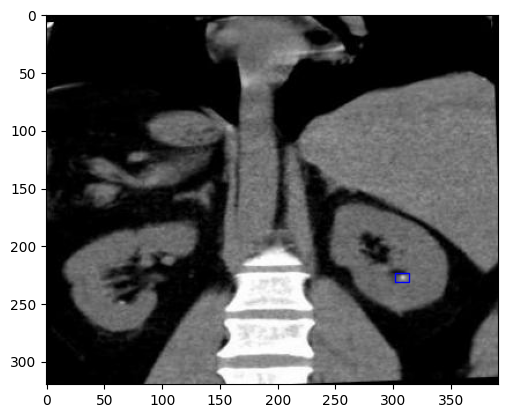

tensor(305.5000) tensor(249.) tensor(9.) tensor(7.)


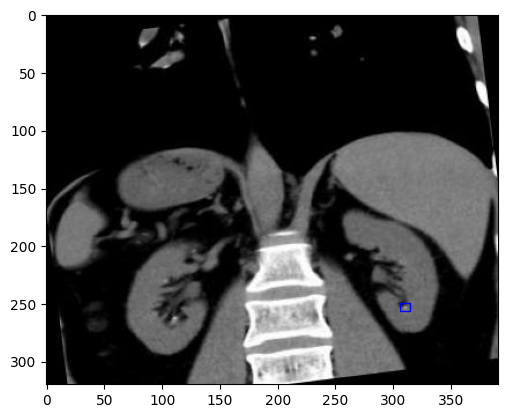

tensor(58.5000) tensor(181.5000) tensor(10.) tensor(12.)


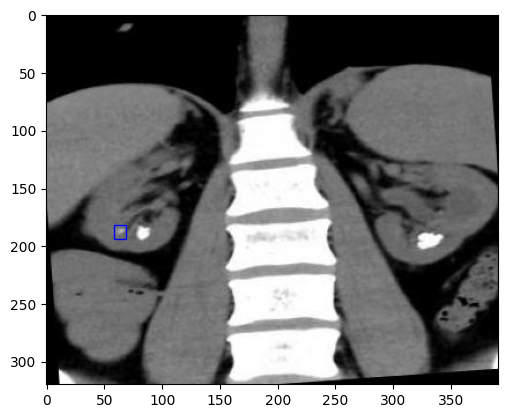

tensor(91.5000) tensor(171.) tensor(8.) tensor(6.)


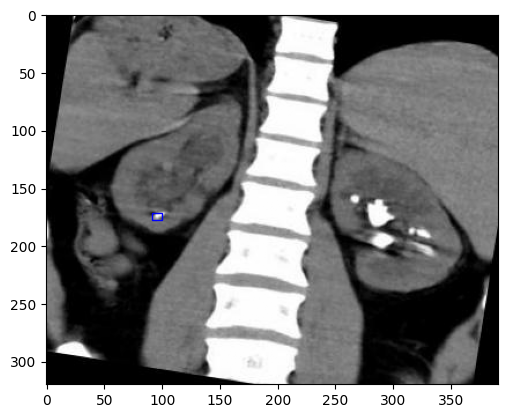

tensor(94.0000) tensor(191.5000) tensor(15.0000) tensor(12.)


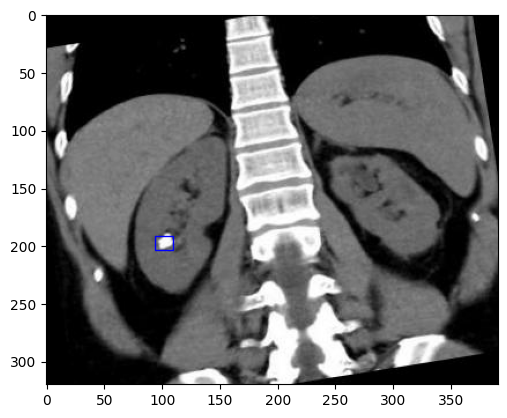

tensor(124.) tensor(205.) tensor(28.) tensor(27.)


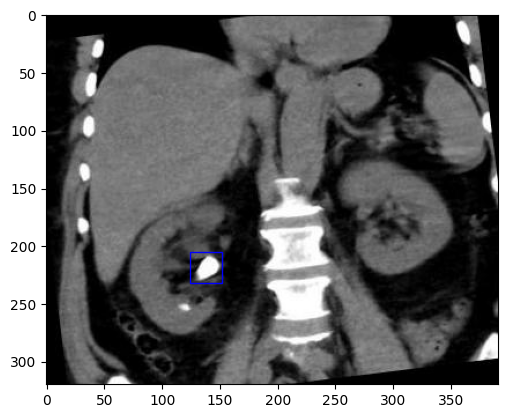

tensor(324.5000) tensor(170.5000) tensor(11.) tensor(7.)


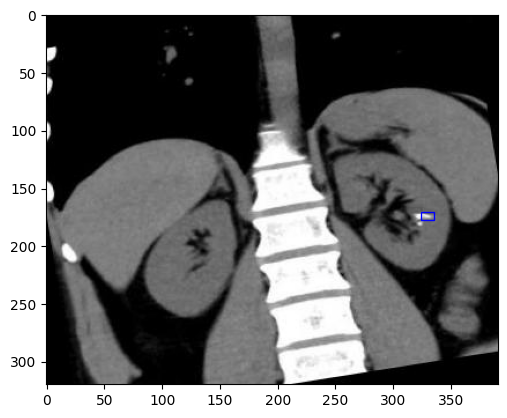

tensor(265.) tensor(185.) tensor(8.) tensor(5.)


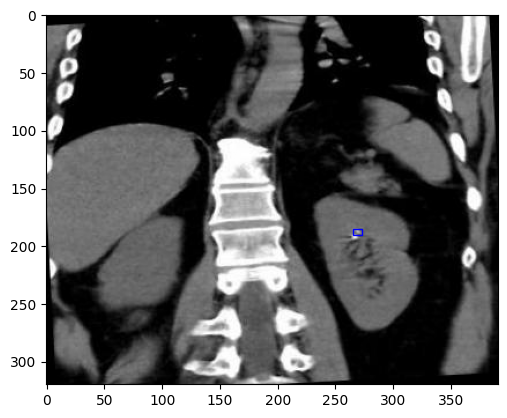

tensor(58.5000) tensor(188.5000) tensor(70.) tensor(61.)


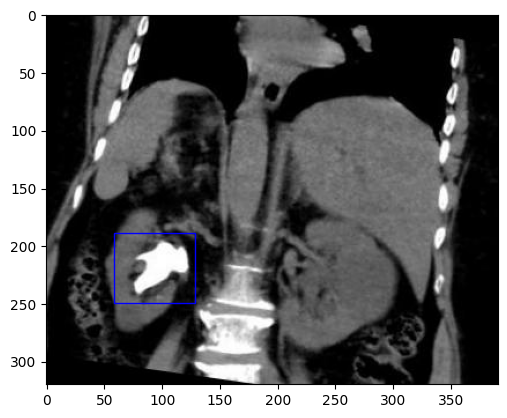

tensor(302.) tensor(223.5000) tensor(8.) tensor(6.)


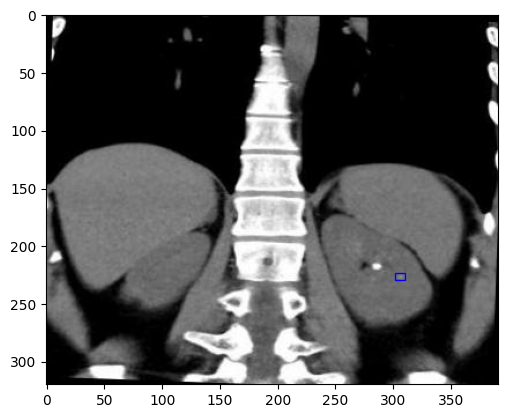

tensor(317.) tensor(257.5000) tensor(10.) tensor(8.)


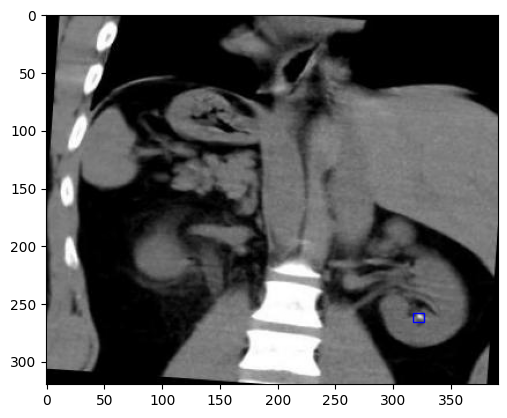

tensor(297.5000) tensor(157.) tensor(9.) tensor(6.)


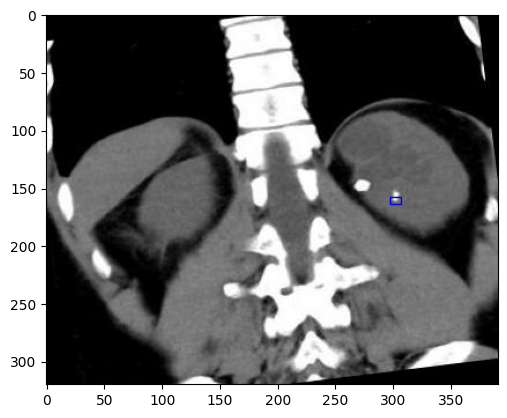

tensor(114.5000) tensor(174.5000) tensor(7.) tensor(5.)


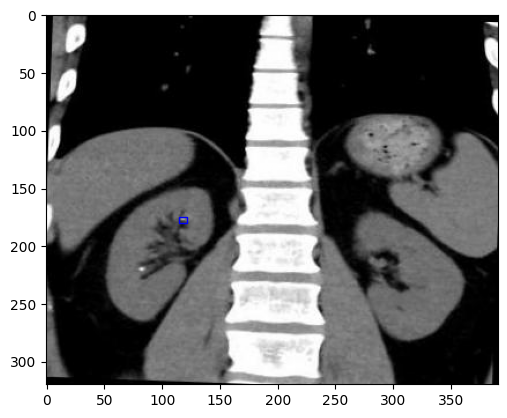

tensor(96.5000) tensor(169.5000) tensor(6.) tensor(6.)


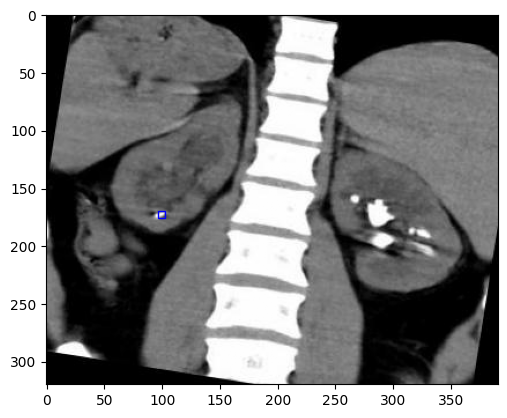

tensor(281.5000) tensor(158.5000) tensor(20.) tensor(25.)


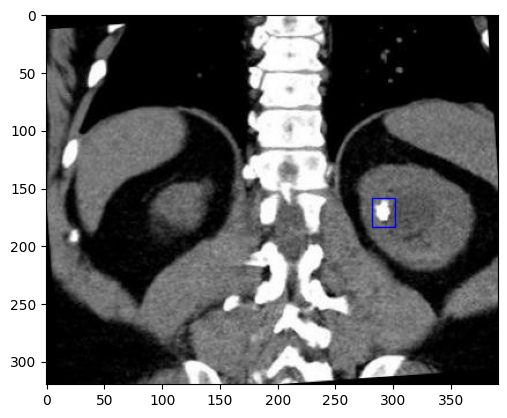

tensor(32.5000) tensor(151.) tensor(93.) tensor(66.)


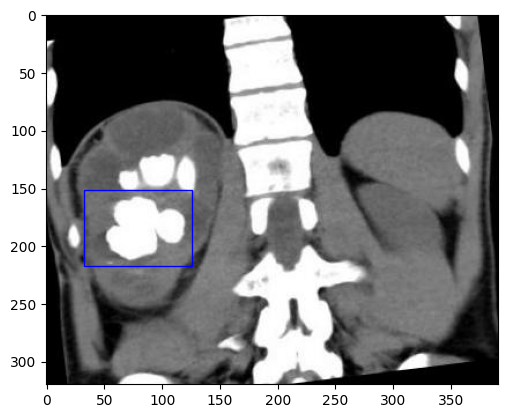

tensor(295.) tensor(193.5000) tensor(6.) tensor(7.)


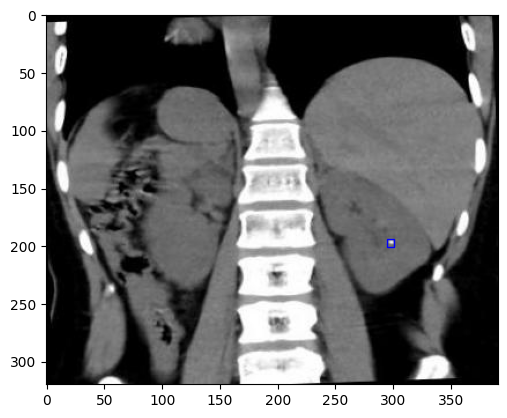

tensor(88.) tensor(188.5000) tensor(6.) tensor(6.)


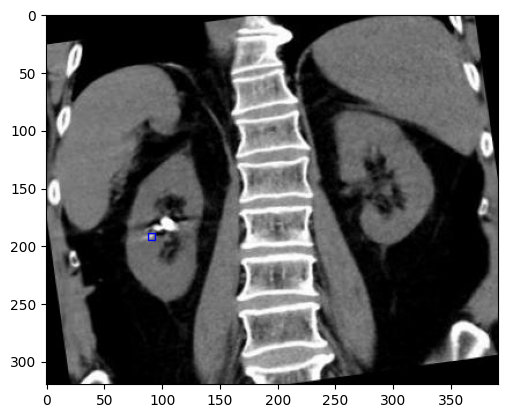

tensor(104.5000) tensor(199.) tensor(10.) tensor(11.)


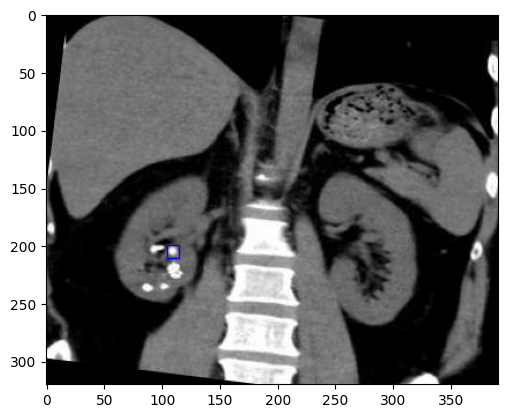

In [9]:
def coordinate_to_drawable_bbox(center_x, center_y, box_width, box_height, image_width, image_height):
    box_width *= image_width
    box_height *= image_height
    center_x = ((2 * center_x * image_width) - box_width) / 2
    center_y = ((2 * center_y * image_height) - box_height) / 2
    return center_x, center_y, box_width, box_height

for images, labels, bboxes in train_dl:
    img = images[0].permute(1,2,0)
    bbox = bboxes[0]
    plt.imshow(img)
    cx, cy, bw, bh = coordinate_to_drawable_bbox(bbox[0],bbox[1],bbox[2],bbox[3],391,320)
    print(cx,cy,bw,bh)
    plt.gca().add_patch(Rectangle((cx,cy),bw,bh,edgecolor='blue',fill=False))
    plt.show()

## Second part : Model training

Code now your model architecture. This time, our architecture will be made of 3 different parts. First of all is the backbone, the CNN used as a feature extractor. Second is the regressor, that use the features extracted by the backbone in order to predict the 4 coordinates of the bounding box (center x of the box, center y of the box, width and height of the box). The last one is the classifier, that use the features to predict the class of the object detected. As stated previously, we only have one class to detect here, so the classifier is not that useful, but for educational interest, we will keep it.

Code the architecture of the model, according to the following requirement : 
 - The backbone is made of 4 convolutional layers activated with ReLU. The 2 first layers have 32 filters and the 2 last have 64 filters. 2 max pooling layers are used, one after the 2 first layers and one after the 2 last layers.
 - The regressor is made of 4 linear layers, 3 of them are activated by ReLU with 128, 64 and 32 filters respectively. You can guess the size and the activation function of the last layer by yourself.
 - The classifier is made of 3 layers with the 2 first are activated by Relu with 64 and 32 filters. You can guess the size and the activation function of the last layer by yourself.
 
To code this architecture, you can either code it as in TP1, or use the [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) function, that allow you to stack the layer into one single variable, which is much more convenient.

Also code the forward function, that should return a tuple : the output of the regressor on one side and the output of the classifier on the other side.

In [10]:

class ObjectDetectionCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(ObjectDetectionCNN, self).__init__()  # b,3,320,391
        self.numClasses = num_classes
        self.backbone1 = torch.nn.Conv2d(3,32,3,padding="same") # b,3,320,391
        self.backbone2 = torch.nn.Conv2d(32,32,3,padding="same") # b,32,320,391
        self.maxpool1 = torch.nn.MaxPool2d(2)                     # b,32,160,195
        self.backbone3 = torch.nn.Conv2d(32,64,3,padding="same") # b,64,160,195
        self.backbone4 = torch.nn.Conv2d(64,64,3,padding="same") # b,64,160,195
        self.maxpool2 = torch.nn.MaxPool2d(2)                     # b,64,80,97

        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(64 * 80 * 97, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 4),
            torch.nn.Softmax()
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64 * 80 * 97, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 2),
            torch.nn.Softmax()
        )

    def forward(self, x):
      x = self.backbone1(x)
      x = self.backbone2(x)
      x = self.maxpool1(x)
      x = self.backbone3(x)
      x = self.backbone4(x)
      x = self.maxpool2(x)
      x = torch.flatten(x,start_dim=1,end_dim=-1)
      bboxes = self.regressor(x)
      classes = self.classifier(x)

      return (bboxes, classes)

Prepare now every hyperparameters you will need for your training : the number of classes, the number of epochs, the model, the loss functions, the optimizer the device, and anything else you would need. 

In [11]:
from re import M
classes_num = 2
my_model = ObjectDetectionCNN(classes_num)
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-4)
my_loss_regressor = torch.nn.MSELoss()
my_loss_classifier = torch.nn.CrossEntropyLoss()
device = 'cpu'
my_model.to(device)

loss_train = []
loss_valid = []



**Training** 
Time for training. For each epoch, train your model on the training set and evaluate it on the validation set. Compute the loss for both tasks. Don't forget to retropropagate your loss during the training step. 
Also compute some metrics for both tasks such as accuracy or mean squared error.
Conclude by analyzing the results obtained by those metrics.

In [12]:
iter = 0

for epoch in tqdm(range(50)):

    iter = iter+1
    print("iter", iter) 

    my_model.train()
    size = len(train_dl.dataset)

    loss_total = 0
    for batch, (X, y, z) in enumerate(train_dl):
        X, y, z = X.to(device), y.long().squeeze().to(device),z.squeeze().to(device)

        pred = my_model(X)
        loss = my_loss_classifier(pred[1],y)+my_loss_regressor(pred[0],z)
        loss_total += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_train.append(loss_total/size)

    my_model.eval()

    for batch, (X,y,z) in enumerate(val_dl):
        X, y, z = X.to(device), y.long().squeeze().to(device),z.squeeze().to(device)     

        pred = my_model(X)
        loss = my_loss_classifier(pred[1],y)+my_loss_regressor(pred[0],z)
        loss_total += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss_valid.append(loss_total/size)

  0%|          | 0/50 [00:00<?, ?it/s]

iter 1


/home/leodebrl98/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  2%|▏         | 1/50 [02:35<2:06:52, 155.37s/it]

iter 2


  4%|▍         | 2/50 [05:12<2:05:21, 156.69s/it]

iter 3


  6%|▌         | 3/50 [07:49<2:02:47, 156.75s/it]

iter 4


  8%|▊         | 4/50 [10:25<1:59:53, 156.38s/it]

iter 5


 10%|█         | 5/50 [13:04<1:57:51, 157.15s/it]

iter 6


 12%|█▏        | 6/50 [15:41<1:55:18, 157.25s/it]

iter 7


 14%|█▍        | 7/50 [18:19<1:52:49, 157.42s/it]

iter 8


 16%|█▌        | 8/50 [20:56<1:50:14, 157.49s/it]

iter 9


 18%|█▊        | 9/50 [23:33<1:47:26, 157.22s/it]

iter 10


 20%|██        | 10/50 [26:10<1:44:50, 157.25s/it]

iter 11


 22%|██▏       | 11/50 [28:47<1:42:05, 157.05s/it]

iter 12


 24%|██▍       | 12/50 [31:24<1:39:27, 157.05s/it]

iter 13


 26%|██▌       | 13/50 [34:00<1:36:38, 156.72s/it]

iter 14


 28%|██▊       | 14/50 [36:38<1:34:11, 157.00s/it]

iter 15


 30%|███       | 15/50 [39:16<1:31:49, 157.41s/it]

iter 16


 32%|███▏      | 16/50 [41:54<1:29:22, 157.72s/it]

iter 17


 34%|███▍      | 17/50 [44:33<1:26:50, 157.90s/it]

iter 18


 36%|███▌      | 18/50 [47:10<1:24:08, 157.76s/it]

iter 19


 38%|███▊      | 19/50 [49:46<1:21:10, 157.12s/it]

iter 20


 40%|████      | 20/50 [52:21<1:18:16, 156.57s/it]

iter 21


 42%|████▏     | 21/50 [54:59<1:15:50, 156.91s/it]

iter 22


 44%|████▍     | 22/50 [57:38<1:13:28, 157.44s/it]

iter 23


 46%|████▌     | 23/50 [1:00:15<1:10:52, 157.50s/it]

iter 24


 48%|████▊     | 24/50 [1:02:51<1:08:01, 156.98s/it]

iter 25


 50%|█████     | 25/50 [1:05:26<1:05:11, 156.46s/it]

iter 26


 52%|█████▏    | 26/50 [1:08:02<1:02:30, 156.27s/it]

iter 27


 54%|█████▍    | 27/50 [1:10:37<59:44, 155.85s/it]  

iter 28


 56%|█████▌    | 28/50 [1:13:12<57:01, 155.51s/it]

iter 29


 58%|█████▊    | 29/50 [1:15:47<54:25, 155.52s/it]

iter 30


 60%|██████    | 30/50 [1:18:22<51:47, 155.37s/it]

iter 31


 62%|██████▏   | 31/50 [1:20:58<49:16, 155.58s/it]

iter 32


 64%|██████▍   | 32/50 [1:23:35<46:49, 156.07s/it]

iter 33


 66%|██████▌   | 33/50 [1:26:11<44:11, 155.95s/it]

iter 34


 68%|██████▊   | 34/50 [1:28:47<41:35, 155.98s/it]

iter 35


 70%|███████   | 35/50 [1:31:22<38:54, 155.63s/it]

iter 36


 72%|███████▏  | 36/50 [1:33:58<36:20, 155.74s/it]

iter 37


 74%|███████▍  | 37/50 [1:36:35<33:49, 156.10s/it]

iter 38


 76%|███████▌  | 38/50 [1:39:12<31:14, 156.24s/it]

iter 39


 78%|███████▊  | 39/50 [1:41:47<28:35, 156.00s/it]

iter 40


 80%|████████  | 40/50 [1:44:23<26:01, 156.10s/it]

iter 41


 82%|████████▏ | 41/50 [1:46:58<23:20, 155.63s/it]

iter 42


 84%|████████▍ | 42/50 [1:49:33<20:43, 155.43s/it]

iter 43


 86%|████████▌ | 43/50 [1:52:07<18:06, 155.19s/it]

iter 44


 88%|████████▊ | 44/50 [1:54:42<15:30, 155.02s/it]

iter 45


 90%|█████████ | 45/50 [1:57:18<12:56, 155.27s/it]

iter 46


 92%|█████████▏| 46/50 [1:59:53<10:21, 155.28s/it]

iter 47


 94%|█████████▍| 47/50 [2:02:30<07:47, 155.72s/it]

iter 48


 96%|█████████▌| 48/50 [2:05:06<05:11, 155.69s/it]

iter 49


 98%|█████████▊| 49/50 [2:07:41<02:35, 155.63s/it]

iter 50


100%|██████████| 50/50 [2:10:18<00:00, 156.36s/it]


## Third part : result analysis
By using the previous plot function you developped, display the image with true bounding box and the predicted bounding box on the test set. Also compute the Intersection Over Union (IOU) for this set. Conclude on your model.

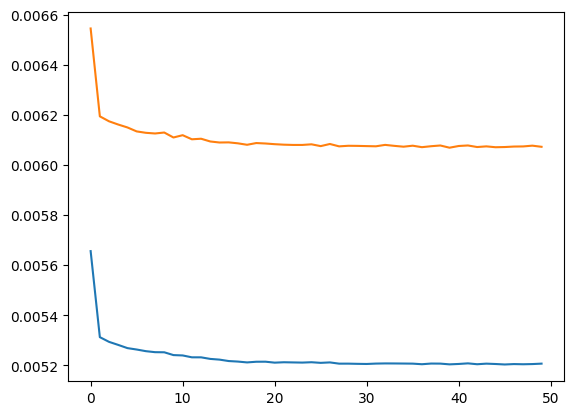

In [13]:
plt.plot(loss_train)
plt.plot(loss_valid)

## Fourth part
In this last part, you are going to use a model designed for object detection namely You Only Look Once (YOLO).
You can install the corresponding library by running the following cell

In [17]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable


**Training**
By following the tutoral [here](https://docs.ultralytics.com/modes/train/), train a new YOLO model for your own data 

In [22]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data='data/data.yaml', epochs=50, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.97 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon Platinum 8173M 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_f

train: Scanning /home/leodebrl98/3A/TP2/data/train/labels... 1054 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:01<00:00, 642.15it/s]

train: New cache created: /home/leodebrl98/3A/TP2/data/train/labels.cache



val: Scanning /home/leodebrl98/3A/TP2/data/valid/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 678.21it/s]

val: New cache created: /home/leodebrl98/3A/TP2/data/valid/labels.cache


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.219       3.13       1.26         58        640: 100%|██████████| 66/66 [01:45<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]

                   all        123        325      0.729      0.199      0.209     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.173      2.009      1.267         44        640: 100%|██████████| 66/66 [01:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        123        325      0.498      0.348      0.298      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.193      1.712      1.328         46        640: 100%|██████████| 66/66 [01:41<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325      0.636      0.585      0.583      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.125      1.413      1.296         48        640: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        123        325      0.685      0.566      0.558      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.119      1.293      1.261         59        640: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        123        325      0.702      0.542      0.586      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G       2.12      1.238      1.243         39        640: 100%|██████████| 66/66 [01:49<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325      0.596      0.591      0.536      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.071       1.23      1.248         53        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        123        325       0.74      0.631      0.656      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.073      1.197      1.261         75        640: 100%|██████████| 66/66 [01:39<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        123        325      0.709      0.639      0.642      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       2.04       1.16      1.231         40        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        123        325      0.762      0.668      0.651      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.059       1.13       1.24         30        640: 100%|██████████| 66/66 [01:40<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        123        325      0.748      0.665      0.688      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G       2.07        1.1      1.234         32        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all        123        325      0.734      0.621      0.668      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.975      1.065      1.205         30        640: 100%|██████████| 66/66 [01:40<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        123        325      0.712      0.631       0.67      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.012      1.067      1.211         39        640: 100%|██████████| 66/66 [01:39<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        123        325      0.763      0.628      0.664      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.999      1.073      1.206         56        640: 100%|██████████| 66/66 [01:39<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325       0.76      0.655       0.65      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.026       1.06      1.219         54        640: 100%|██████████| 66/66 [01:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        123        325      0.771      0.654      0.661      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.005      1.036      1.189         35        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        123        325      0.783      0.594      0.652      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.964      1.021      1.184         33        640: 100%|██████████| 66/66 [01:43<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

                   all        123        325      0.785      0.683      0.696      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.977      1.019      1.171         55        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        123        325       0.82      0.661      0.705      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.996      1.041      1.197         48        640: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        123        325      0.731      0.651      0.686      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.939     0.9873      1.165         37        640: 100%|██████████| 66/66 [01:41<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

                   all        123        325      0.757      0.677      0.704       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.938      1.008      1.177         39        640: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        123        325      0.795      0.677      0.706      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.925     0.9551      1.158         46        640: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325      0.749      0.707      0.718      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.909      0.964      1.174         67        640: 100%|██████████| 66/66 [01:55<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

                   all        123        325      0.752      0.681       0.68       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.893     0.9385      1.184         48        640: 100%|██████████| 66/66 [01:55<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]

                   all        123        325      0.784      0.668       0.71      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.903     0.9666      1.149         64        640: 100%|██████████| 66/66 [01:53<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        123        325      0.802      0.687       0.72      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.857     0.9375      1.141         48        640: 100%|██████████| 66/66 [01:51<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        123        325      0.741      0.695      0.727      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.896     0.9322      1.142         54        640: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        123        325      0.797      0.646      0.677      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.911     0.9499      1.142         43        640: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325      0.777      0.706      0.716      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.886     0.9436      1.151         44        640: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        123        325      0.763      0.705      0.718      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.851     0.9128      1.138         29        640: 100%|██████████| 66/66 [01:46<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        123        325       0.75      0.683      0.719      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.856     0.9189       1.14         50        640: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        123        325      0.779      0.652      0.707      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G       1.84     0.9087       1.13         51        640: 100%|██████████| 66/66 [01:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

                   all        123        325      0.752       0.72      0.727      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.809     0.8903      1.123         29        640: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

                   all        123        325      0.772      0.683      0.736      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.798     0.8611      1.114         59        640: 100%|██████████| 66/66 [01:50<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        123        325       0.76      0.708      0.737      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.813     0.8806      1.122         47        640: 100%|██████████| 66/66 [01:47<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

                   all        123        325      0.804      0.692      0.753      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.807     0.8777      1.106         56        640: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        123        325       0.83      0.671      0.711      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.774     0.8654      1.114         31        640: 100%|██████████| 66/66 [01:45<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all        123        325      0.776      0.695      0.721      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.768     0.8479      1.092         42        640: 100%|██████████| 66/66 [01:45<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        123        325      0.778      0.658      0.721      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.776     0.8423      1.114         42        640: 100%|██████████| 66/66 [01:45<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]

                   all        123        325      0.765      0.655      0.713      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.776     0.8323      1.104         42        640: 100%|██████████| 66/66 [01:46<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        123        325      0.746      0.711      0.728      0.293


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.744     0.8197      1.127         22        640: 100%|██████████| 66/66 [01:45<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all        123        325      0.758      0.652      0.692      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.725     0.8199       1.11         33        640: 100%|██████████| 66/66 [01:51<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all        123        325      0.748       0.68      0.719      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.729     0.8081      1.106         31        640: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        123        325      0.723      0.634      0.666      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.709     0.8048      1.121         22        640: 100%|██████████| 66/66 [01:43<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        123        325      0.788      0.664      0.703      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.693     0.7938      1.108         25        640: 100%|██████████| 66/66 [01:51<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        123        325      0.743      0.676      0.712        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.691     0.7789      1.103         31        640: 100%|██████████| 66/66 [02:35<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]

                   all        123        325      0.781      0.649      0.687      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.648     0.7691      1.085         37        640: 100%|██████████| 66/66 [02:33<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

                   all        123        325      0.783      0.677      0.716      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.658     0.7689      1.077         20        640: 100%|██████████| 66/66 [02:26<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

                   all        123        325      0.769      0.664      0.695      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.633     0.7551      1.092         28        640: 100%|██████████| 66/66 [02:20<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all        123        325      0.767      0.671      0.702      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.617     0.7424      1.065         30        640: 100%|██████████| 66/66 [02:17<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]

                   all        123        325      0.798      0.658      0.701      0.295



50 epochs completed in 1.583 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon Platinum 8173M 2.00GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


                   all        123        325      0.807      0.689      0.753      0.314
Speed: 1.0ms preprocess, 29.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train6


Predict and evaluate the results you obtained similarily than for your model. Conclude.

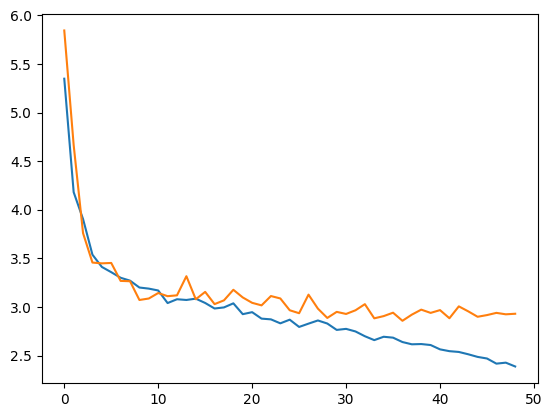

In [160]:
box_trainloss_YOLO = pd.read_csv('runs/detect/train6/results.csv',usecols=[1]).values.tolist()
cls_trainloss_YOLO = pd.read_csv('runs/detect/train6/results.csv',usecols=[2]).values.tolist()
box_valloss_YOLO = pd.read_csv('runs/detect/train6/results.csv',usecols=[8]).values.tolist()
cls_valloss_YOLO = pd.read_csv('runs/detect/train6/results.csv',usecols=[9]).values.tolist()

A=[]
B=[]
for i in range(0,49) :
    A.append(box_trainloss_YOLO[i][0] + cls_trainloss_YOLO[i][0])
    B.append(box_valloss_YOLO[i][0] + cls_valloss_YOLO[i][0])

#plt.plot(loss_train)
#plt.plot(loss_valid)
plt.plot(A)
plt.plot(B)

In [ ]:
On this model, the loss is higher than the previous one. However, we should try with more epochs because the train loss is still decreasing.
I apologize it ran for 2 hours with 50 epochs, I could not add more. We see it decrease lower than the first model.